#Retinal Blood vessel segmentation by CNN

# Setting up the drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Loading and preparing data

In [0]:
import os
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

In [0]:
data_path = '/content/gdrive/My Drive/Retinal/training/'

image_width = 565
image_height = 584

In [5]:
img_data_path = os.path.join(data_path, 'images')
seg_data_path = os.path.join(data_path, '1st_manual')

print(img_data_path)
print(seg_data_path)

images = sorted(os.listdir(img_data_path))
segs = sorted(os.listdir(seg_data_path))
num_images = len(images)
num_segs = len(segs)
print('number of images:',num_images , num_segs)

/content/gdrive/My Drive/Retinal/training/images
/content/gdrive/My Drive/Retinal/training/1st_manual
number of images: 20 20


In [0]:
imgs_array = np.ndarray((num_images, image_width, image_height), dtype=np.uint8)
segs_array = np.ndarray((num_segs, image_width, image_height), dtype=np.uint8)

In [7]:
print('Creating training images arrays...')
n = 0
good_imgs=[]
for image_name in images:
    #print('reading image %s    %d' % (image_name,n+1))
    img = Image.open(os.path.join(img_data_path,image_name)).convert('L') 
    good_imgs.append(image_name)
    img = np.array(img.resize((image_height,image_width)))
    imgs_array[n] = img
    n +=1

np.save('/content/gdrive/My Drive/Retinal/training/imgs_train.npy', imgs_array[0:len(good_imgs)])
print(len(good_imgs),imgs_array.shape)


n = 0
good_imgs=[]
for image_name in segs:
    #print('reading seg %s    %d' % (image_name,n+1))
    img = Image.open(os.path.join(seg_data_path,image_name)).convert('L')
    good_imgs.append(image_name)
    img = np.array(img.resize((image_height,image_width)))
    segs_array[n] = img
    n +=1
  
np.save('/content/gdrive/My Drive/Retinal/training/seg_train.npy', segs_array[0:len(good_imgs)])
print('finished saving image arrays.')

print(segs_array.shape)

Creating training images arrays...
20 (20, 565, 584)
finished saving image arrays.
(20, 565, 584)


In [8]:
imgs_array[0:len(good_imgs)].shape

(20, 565, 584)

In [9]:
'''
img_no=10
print(imgs_array.shape)
w=Image.fromarray(imgs_array[img_no].reshape(image_width,image_height))
display(w)

print(imgs_array.shape)
w=Image.fromarray(segs_array[img_no].reshape(image_width,image_height))
display(w)
'''

'\nimg_no=10\nprint(imgs_array.shape)\nw=Image.fromarray(imgs_array[img_no].reshape(image_width,image_height))\ndisplay(w)\n\nprint(imgs_array.shape)\nw=Image.fromarray(segs_array[img_no].reshape(image_width,image_height))\ndisplay(w)\n'

In [0]:
del imgs_array
del segs_array

In [0]:
#making patches of size 128*128
patch_size=128
step_size=16
imgs = np.load(data_path+'imgs_train.npy')
segs = np.load(data_path+'seg_train.npy')

from skimage.util.shape import view_as_windows

imgs_patches = np.array([])
segs_patches = np.array([])
for i in range(imgs.shape[0]):
  patches=view_as_windows(imgs[i], (patch_size, patch_size), step=step_size)
  patches=patches.reshape(-1,patch_size,patch_size)
  seg_pats=view_as_windows(segs[i], (patch_size, patch_size), step=step_size)
  seg_pats=seg_pats.reshape(-1,patch_size,patch_size)
 
  if i==0:
    imgs_patches=patches
    segs_patches=seg_pats
  else:
    imgs_patches=np.append(imgs_patches,patches,axis=0)
    segs_patches=np.append(segs_patches,seg_pats,axis=0)


In [12]:
patches.shape, imgs_patches.shape, segs_patches.shape

((812, 128, 128), (16240, 128, 128), (16240, 128, 128))

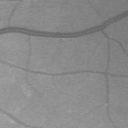

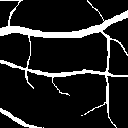

In [13]:
w=Image.fromarray(imgs_patches[190].reshape(patch_size,patch_size))
display(w)
w=Image.fromarray(segs_patches[190].reshape(patch_size,patch_size))
display(w)

# Training

In [0]:
from __future__ import print_function
import os
from PIL import Image
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, \
                          Flatten, Dense, UpSampling2D,Dropout,BatchNormalization,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split 

In [15]:

imgs_patches = imgs_patches[:,:,:,np.newaxis]
segs_patches = segs_patches[:,:,:,np.newaxis]

imgs_patches = imgs_patches.astype('float32')
imgs_patches /=255.0
segs_patches = segs_patches.astype('float32')
segs_patches /=255.0

#segs_patches=to_categorical(segs_patches, num_classes=2)
segs_patches.shape

(16240, 128, 128, 1)

In [16]:
imgs_patches.shape

(16240, 128, 128, 1)

In [17]:
train_imgs, valid_imgs, train_segs, valid_segs = \
                    train_test_split(imgs_patches, segs_patches, test_size=0.2, random_state=54)

del imgs_patches
del segs_patches
import gc
gc.collect()

10

In [0]:
from numpy.random import seed
seedval=29
seed(seedval*1)
from tensorflow import set_random_seed
set_random_seed(seedval*2)

Model architecture

In [19]:
def BN_ReLU(input_features): 
    output_features = BatchNormalization()(input_features)
    output_features = Activation('relu')(output_features)
    return output_features


def Model_Architecture(input_layer):
    initial_num_filters=16
    input_layer = BatchNormalization()(input_layer)  #sdg 
    #in:128--out:64
    conv1 = Conv2D(initial_num_filters * 1, (3, 3), padding="same")(input_layer)
    out = BN_ReLU(conv1) 
    out = MaxPooling2D((2, 2))(out)   #check stride? sdg
    out = Dropout(0.2)(out)
    #in:64--out:32
    conv2 = Conv2D(initial_num_filters * 2, (3, 3), padding="same")(out)
    out = BN_ReLU(conv2) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:32--out:16
    conv3 = Conv2D(initial_num_filters * 3, (3, 3), padding="same")(out)
    out = BN_ReLU(conv3) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:16--out:8
    conv4 = Conv2D(initial_num_filters * 4, (3, 3), padding="same")(out)
    out = BN_ReLU(conv4) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:8--out:4
    conv5 = Conv2D(initial_num_filters * 5, (3, 3), padding="same")(out)
    out = BN_ReLU(conv5) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:4--out:2
    conv6 = Conv2D(initial_num_filters * 6, (3, 3), padding="same")(out)
    out = BN_ReLU(conv6) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:2--out:1
    conv7 = Conv2D(initial_num_filters * 7, (3, 3), padding="same")(out)
    out = BN_ReLU(conv7) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    

    #Decoding
    convT7 = Conv2DTranspose(initial_num_filters * 7, (3, 3), strides=(2, 2), padding="same")(out)
    convT7 = Conv2D(initial_num_filters * 7, (3, 3), padding="same")(convT7)
    out = concatenate([convT7, conv7])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT6 = Conv2DTranspose(initial_num_filters * 6, (3, 3), strides=(2, 2), padding="same")(out)
    convT6 = Conv2D(initial_num_filters * 6, (3, 3), padding="same")(convT6)
    out = concatenate([convT6, conv6])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    
    convT5 = Conv2DTranspose(initial_num_filters * 5, (3, 3), strides=(2, 2), padding="same")(out)
    convT5 = Conv2D(initial_num_filters * 5, (3, 3), padding="same")(convT5)
    out = concatenate([convT5, conv5])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)

    
    convT4 = Conv2DTranspose(initial_num_filters * 4, (3, 3), strides=(2, 2), padding="same")(out)
    convT4 = Conv2D(initial_num_filters * 4, (3, 3), padding="same")(convT4)
    out = concatenate([convT4, conv4])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    
    convT3 = Conv2DTranspose(initial_num_filters * 3, (3, 3), strides=(2, 2), padding="same")(out)
    convT3 = Conv2D(initial_num_filters * 3, (3, 3), padding="same")(convT3)
    out = concatenate([convT3, conv3])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT2 = Conv2DTranspose(initial_num_filters * 2, (3, 3), strides=(2, 2), padding="same")(out)
    convT2 = Conv2D(initial_num_filters * 2, (3, 3), padding="same")(convT2)
    out = concatenate([convT2, conv2])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT1 = Conv2DTranspose(initial_num_filters * 1, (3, 3), strides=(2, 2), padding="same")(out)
    convT1 = Conv2D(initial_num_filters * 1, (3, 3), padding="same")(convT1)
    out = concatenate([convT1, conv1])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(out)
    return output_layer

  
input_layer=Input(shape=(128,128,1))
output_layer=Model_Architecture(input_layer)

model=Model(inputs=input_layer,outputs=output_layer)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [0]:
import tensorflow as tf
def focal_loss(gamma=2., alpha=.60):
    def focal_loss_fixed(y_true, y_pred):
        pt1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        # clip to prevent NaN's and Inf's
        pt1 = K.clip(pt1, K.epsilon(), 1-K.epsilon())
        pt0 = K.clip(pt0, K.epsilon(), 1-K.epsilon())
        return -K.mean(alpha * K.pow(1. - pt1, gamma) * K.log(pt1), axis=-1) \
               -K.mean((1-alpha) * K.pow( pt0, gamma) * K.log(1. - pt0) ,axis=-1)
    return focal_loss_fixed
 
#loss =[focal_loss(gamma=0.0,alpha=0.60)], 'categorical_crossentropy'

In [0]:
model.compile(optimizer=Adam(lr=0.001), loss = [focal_loss(gamma=0.1,alpha=0.60)] , metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model_checkpoint = ModelCheckpoint(data_path+"checkpoint/keras.model", monitor='val_loss', save_best_only=True, verbose=1)

In [0]:
batchsize=64
# we create two instances with the same arguments
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = seedval*4


image_generator = image_datagen.flow(train_imgs, batch_size=batchsize, shuffle=True, seed=seed)
mask_generator = mask_datagen.flow(train_segs, batch_size=batchsize, shuffle=True, seed=seed)


# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(len(train_imgs)/batchsize),
    validation_data = (valid_imgs, valid_segs),
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    initial_epoch=0,
    epochs=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
203/203 [==============================] - 79s 389ms/step - loss: 0.1284 - acc: 0.8932 - val_loss: 0.0873 - val_acc: 0.9373

Epoch 00001: val_loss improved from inf to 0.08725, saving model to /content/gdrive/My Drive/Retinal/training/checkpoint/keras.model
Epoch 2/100
203/203 [==============================] - 70s 345ms/step - loss: 0.0781 - acc: 0.9409 - val_loss: 0.0725 - val_acc: 0.9478

Epoch 00002: val_loss improved from 0.08725 to 0.07254, saving model to /content/gdrive/My Drive/Retinal/training/checkpoint/keras.model
Epoch 3/100
203/203 [==============================] - 70s 345ms/step - loss: 0.0703 - acc: 0.9452 - val_loss: 0.0659 - val_acc: 0.9509

Epoch 00003: val_loss improved from 0.07254 to 0.06594, saving model to /content/gdrive/My Drive/Retinal/training/checkpoint/keras.model
Epoch 4/100
203/203 [==============================] - 70s 345ms/step - loss: 0.0667 - acc: 0.9473 - val_loss: 0.0603 - val_acc: 0.953

In [0]:
'''
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="Training loss")
plt.plot(model_history.history["val_loss"], label="Validation loss")
plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="*", color="y", label="Best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
'''

'\nplt.figure(figsize=(8, 8))\nplt.title("Learning curve")\nplt.plot(model_history.history["loss"], label="Training loss")\nplt.plot(model_history.history["val_loss"], label="Validation loss")\nplt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="*", color="y", label="Best model")\nplt.xlabel("Epochs")\nplt.ylabel("Loss")\nplt.legend();\n'

# Loading the trained model

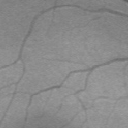

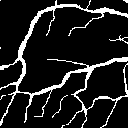

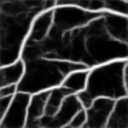

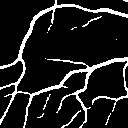

In [52]:
from keras.models import load_model
model = load_model(data_path+'checkpoint/keras.model', custom_objects={'focal_loss_fixed': focal_loss(gamma=2.,alpha=0.12)})
predicted_val = model.predict(valid_imgs)

c=0  #0 or 1

imageNo=40 #40 80
#image
w=Image.fromarray(255*valid_imgs[imageNo,:,:,0]).convert('L')
display(w)

#real seg
w=Image.fromarray(255*valid_segs[imageNo,:,:,c]).convert('L')
display(w)

#predicted seg
w=Image.fromarray(255*predicted_val[imageNo,:,:,c]).convert('L')
display(w)

#predicted seg -- rounded with threshold
thresh=0.5
preds_valid_rounded = np.round(predicted_val>thresh)
preds_valid_rounded=preds_valid_rounded.astype(np.float32)

w=Image.fromarray(255*preds_valid_rounded[imageNo,:,:,c].astype('uint8')).convert('L')
display(w)

# Evaluation of the trained model on validation data

In [53]:
#defining dice metric
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
  
  
dice_result=dice_coef(valid_segs[:,:,:,c],preds_valid_rounded[:,:,:,c])
print('Dice='+str(K.eval(dice_result)))

Dice=0.83405024


In [0]:
y_true = valid_segs[:,:,:,c].flatten()
y_pred = preds_valid_rounded[:,:,:,c].flatten()  #with a specific thresh
y_pred_prob = predicted_val[:,:,:,c].flatten()

from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[1,0])
#positive:vessel:1:mask:white
#nagative:backgrnd:0:black

In [0]:
from sklearn import metrics
report=metrics.classification_report(y_true, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

         0.0     0.9779    0.9795    0.9787  47118179
         1.0     0.8394    0.8288    0.8341   6097053

   micro avg     0.9622    0.9622    0.9622  53215232
   macro avg     0.9086    0.9041    0.9064  53215232
weighted avg     0.9620    0.9622    0.9621  53215232



Confusion matrix, without normalization
[[ 5053334  1043719]
 [  967190 46150989]]
Normalized confusion matrix
[[0.83 0.17]
 [0.02 0.98]]


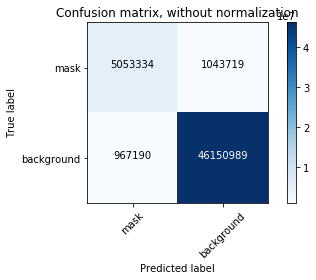

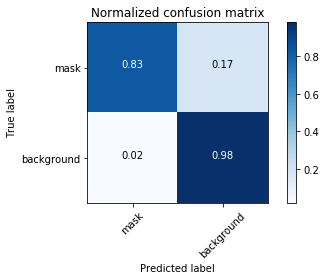

In [0]:
#Confusion Matrix
import itertools


#plot Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
np.set_printoptions(precision=2)

class_names=['mask','background']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

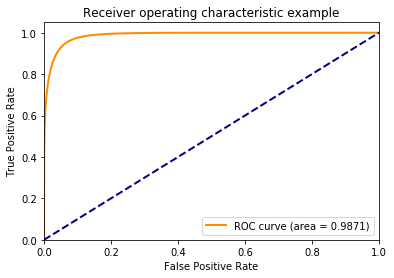

In [0]:
#Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [0]:
#accuracy Acc = (TP+TN)/(TP+TN+FP+FN)

acc=metrics.accuracy_score(y_true, y_pred, normalize=True)
print('Accuracy = '+str(acc))

Accuracy = 0.962211778011228


In [0]:
#recall rc=tp / (tp + fn)
rc=metrics.recall_score(y_true, y_pred, average='micro') 

In [0]:
jc=metrics.jaccard_similarity_score(y_true, y_pred)
print('Jaccard_similarity_score = '+str(jc))

Jaccard_similarity_score = 0.962211778011228


In [0]:
#Matthews correlation coefficient (MCC)
mcc=metrics.matthews_corrcoef(y_true, y_pred)  
print('MCC = '+str(mcc))

MCC = 0.8127501627305902


In [0]:
#check balance---it is imbalanced
6097053/47118179

0.1293991645984451

In [0]:
#in binary classification, 
#recall of the positive class is 
#also known as “sensitivity”; 
#recall of the negative class is “specificity”.

In [0]:
#precision pr=tp / (tp + fp) 
pr=metrics.precision_score(y_true, y_pred, average='micro')   #micro macro?
pr

0.962211778011228

#Lets use max votes

In [0]:
from keras.models import load_model
saved_models=['kerasg3beta60','kerasg2beta88','kerasg2beta70','kerasg2beta60']
#first saved model
model = load_model(data_path+'checkpoint/kerasg0.1beta60.model', custom_objects={'focal_loss_fixed': focal_loss(gamma=2.,alpha=0.12)})
predicted_val = model.predict(valid_imgs)
predicted_val_sums=predicted_val
#rest of models
for modelName in saved_models:
  model = load_model(data_path+'checkpoint/'+ modelName + '.model', custom_objects={'focal_loss_fixed': focal_loss(gamma=2.,alpha=0.12)})
  predicted_val = model.predict(valid_imgs)
  predicted_val_sums = predicted_val_sums+predicted_val

predicted_val_average=predicted_val_sums/5

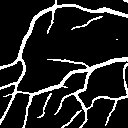

In [0]:
c=0  #0 or 1

imageNo=40 #40 80
#predicted seg -- rounded with threshold
thresh=0.5
predicted_val = predicted_val_average
preds_valid_rounded = np.round(predicted_val>thresh)
preds_valid_rounded=preds_valid_rounded.astype(np.float32)
w=Image.fromarray(255*preds_valid_rounded[imageNo,:,:,c].astype('uint8')).convert('L')
display(w)

y_true = valid_segs[:,:,:,c].flatten()
y_pred = preds_valid_rounded[:,:,:,c].flatten()  #with a specific thresh
y_pred_prob = predicted_val[:,:,:,c].flatten()

In [0]:
dice_result=dice_coef(valid_segs[:,:,:,c],preds_valid_rounded[:,:,:,c])
print('Dice='+str(K.eval(dice_result)))

Dice=0.8368313


In [0]:
y_true = valid_segs[:,:,:,c].flatten()
y_pred = preds_valid_rounded[:,:,:,c].flatten()  #with a specific thresh
y_pred_prob = predicted_val[:,:,:,c].flatten()

from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[1,0])
#positive:vessel:1:mask:white
#nagative:backgrnd:0:black

In [49]:
from sklearn import metrics
report=metrics.classification_report(y_true, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

         0.0     0.9832    0.9726    0.9779  47118179
         1.0     0.8045    0.8719    0.8368   6097053

   micro avg     0.9610    0.9610    0.9610  53215232
   macro avg     0.8939    0.9222    0.9074  53215232
weighted avg     0.9628    0.9610    0.9617  53215232



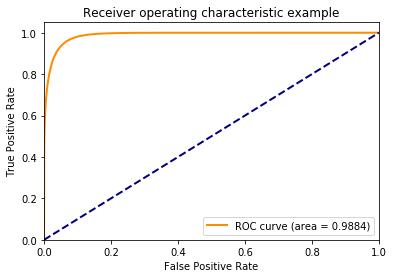

In [50]:
#Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()